In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image


%matplotlib inline  
import pickle
from scipy.sparse.csgraph import shortest_path
from sklearn.manifold import MDS
import pandas as pd

In [2]:
def make_distance_mat(drive_times,cities):
    n=len(cities)
    D=np.zeros([n,n])
    for (src,dst,t) in drive_times[['Source','Destination','DriveTime']].values:
        i=cities.index(src)
        j=cities.index(dst)
        D[i,j]=t
    return D

def align(X_new,X_orig,indices):  
    T=np.hstack([X_new,np.ones((len(X_new),1))])
    A=np.linalg.solve(T[indices],X_orig[indices])
    return T.dot(A)

def hour_to_str(h):
    return "%02d" % int(h) +":%02d" % int(60*(h%1.))


def plot_map(scale=6):    
    background=image.imread('330_315_310_355.png')
    top,bottom,left,right=33.0,31.0,31.5,35.5
    
    left_offset=2.
    bottom_offset = 0.5
    left_=left+left_offset
    bottom_=bottom+bottom_offset
    
    figsize=((right-left_)*scale,(top-bottom_)*scale)
    plt.figure(figsize=figsize)
    plt.xlim([left_,right])
    plt.ylim([bottom_,top])
    plt.imshow(background,extent=(left, right, bottom, top))


## Load locations, drive times, and plot ctual locations

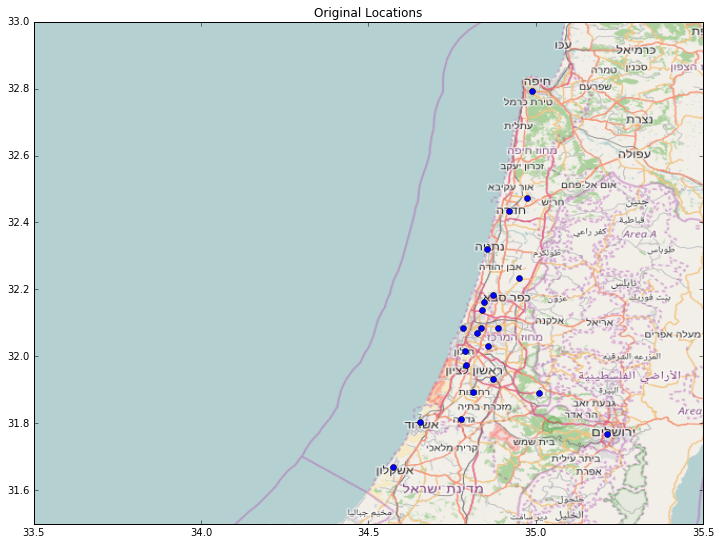

In [3]:
city_locs=pd.read_csv('city_locations.csv')
drive_times=pd.read_csv('drive_times_210617.csv')
cities=list(city_locs['City'])
X_geo=city_locs[['North','East']].values

plot_map(scale=6)
plt.plot(X_geo[:,0],X_geo[:,1],'o')
plt.title('Original Locations')

## Compute drive time embedding for 8AM:

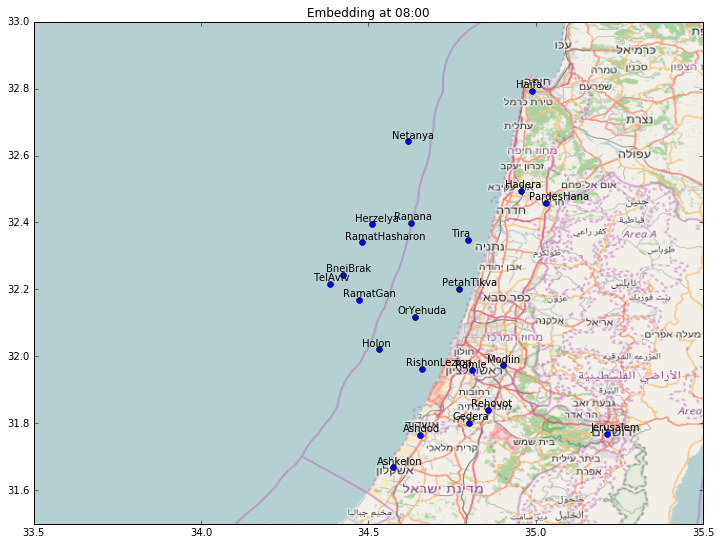

In [4]:
## Define pairwise dinstance between two cities as the time to drive between them
hour=8
D=make_distance_mat(drive_times[drive_times.Hour==hour],cities)
## Make the distance symmetric by maximizing
DD=0.5*(D+D.T)
#DD=np.maximum(D,D.T)
## Removes any violations of the traingle inequality
DD=shortest_path(DD)
## Multidimensional
mds=MDS(dissimilarity='precomputed',eps=1e-8)
X_hour=mds.fit_transform(DD)

## X_hour is now an embedding of the cities, but it's arbitrarily flipped/rotated compared to the true locations,
## we align it using 3 points:
align_indices=[cities.index(c) for c in ['Ashkelon','Jerusalem','Haifa']]
X_hour=align(X_hour,X_geo,align_indices)

plot_map(scale=6)
plt.plot(X_hour[:,0],X_hour[:,1],'bo')
for city,(x,y) in zip(cities,X_hour):
    plt.text(x-0.05, y+0.01, city, fontsize=10)

plt.title('Embedding at '+hour_to_str(hour))

## Compute for all hours:

In [5]:
### Wrap all the above in a single function:
def embedd_and_align(drive_times,hour):
    D=make_distance_mat(drive_times[drive_times.Hour==hour],cities)
    DD=np.maximum(D,D.T)
    DD=shortest_path(DD)
    mds=MDS(dissimilarity='precomputed')
    X_hour=mds.fit_transform(DD)
    align_indices=[cities.index(c) for c in ['Ashkelon','Jerusalem','Haifa']]
    X_hour=align(X_hour,X_geo,align_indices)
    return X_hour


hours=np.unique(drive_times.Hour.values)

## Uncomment this to print to print specific hours:
#for hour in hours[:20]:
#    plot_map()
#    X_hour=embedd_and_align(drive_times,hour)
#    plt.plot(X_hour[:,0],X_hour[:,1],'bo')
#    for city,(x,y) in zip(cities,X_hour):
#        plt.text(x-0.05, y+0.01, city, fontsize=10)
#    plt.title('Hour = '+str(hour))
#    ## Uncomment this to save the image:
#    plt.savefig(r'output\fig'+str(hour)+'.png')

## Save to PDF

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
with PdfPages(r'All_Embeddings.pdf') as pdf:
    plot_map(scale=6)
    plt.plot(X_geo[:,0],X_geo[:,1],'o')
    for city,(x,y) in zip(cities,X_geo):
        plt.text(x-0.05, y+0.01, city, fontsize=10)
    plt.title('Actual Locations')
    pdf.savefig()
    plt.close()
    for hour in hours:
        plot_map(scale=5)
        X_hour=embedd_and_align(drive_times,hour)
        ## Trick:
        ## Make sure that Tel Aviv is west of Tira and Petah Tikva, this protects us against randomality in the eigenvalue computation
        ## where the second and third eigenvalues switch places sometimes
        while(X_hour[cities.index('TelAviv'),0]>X_hour[cities.index('Tira'),0] or \
              X_hour[cities.index('TelAviv'),0]>X_hour[cities.index('PetahTikva'),0]):
            X_hour=embedd_and_align(drive_times,hour)    
        plt.plot(X_hour[:,0],X_hour[:,1],'bo')
        for city,(x,y) in zip(cities,X_hour):
            plt.text(x-0.05, y+0.01, city, fontsize=10)
        plt.title('Embedding at '+hour_to_str(hour))
        ## Uncomment this to save the image:
        pdf.savefig()
        plt.close()
